In [3]:
import numpy as np
import matplotlib
#matplotlib.rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import matplotlib.pyplot as plt

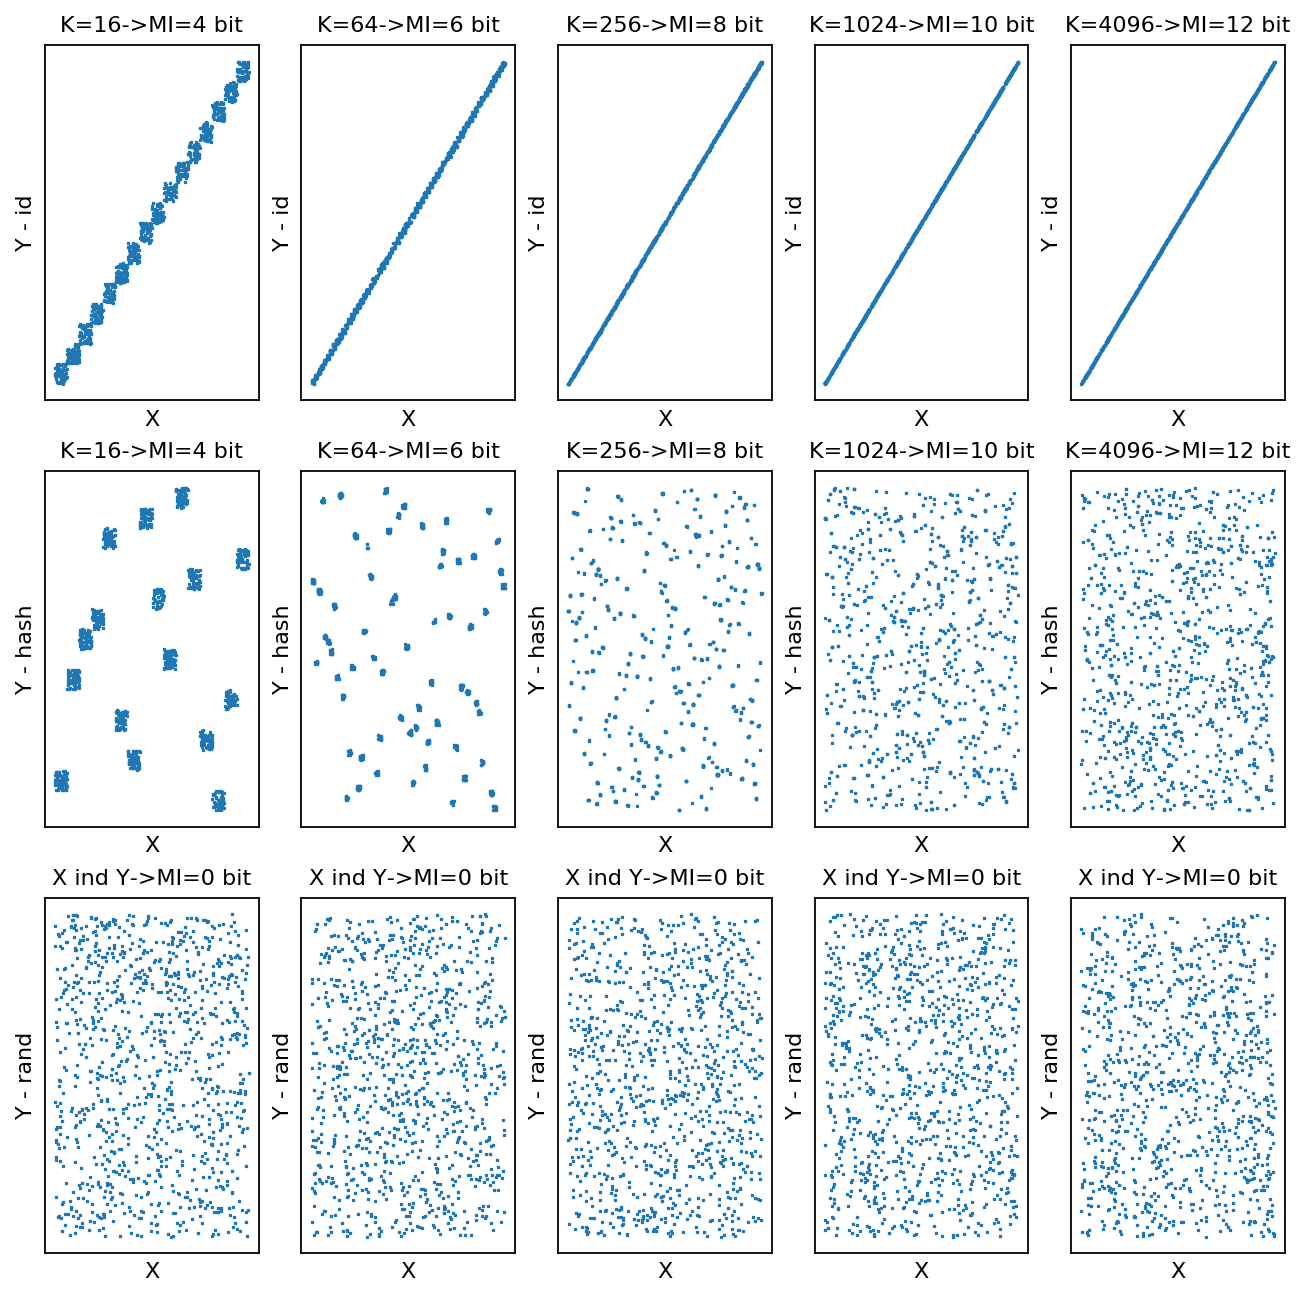

In [6]:
def permute(i):
    return i

modexp = np.frompyfunc(pow, 3, 1)

tables = {}
def hasher(i, k):
    if k not in tables:
        np.random.seed(0)
        tables[k] = np.arange(k)
        np.random.shuffle(tables[k])
    if (i>=k).any():
        print i, k
    return tables[k][i]

def generate_example(permuter, N, K):
    x = np.random.uniform(size=N)
    x_bins = (x*K).astype(int)
    
    if permuter == 'rand':
        y = np.random.uniform(size=N)
    else:
        if permuter == 'id':
            y_bins = x_bins
        elif permuter == 'hash':
            y_bins = hasher(x_bins, K)
        y = (y_bins+np.random.uniform(size=len(y_bins))).astype(float) / float(K)
    return x, y

N = 1000
K = [4**2, 4**3, 4**4, 4**5, 4**6]

permuters = ['id', 'hash', 'rand']

plt.figure(figsize=(10, 10), dpi=160)
cols = len(K)
fontsize=10
for i, permuter in enumerate(permuters):
    for plot_idx, k in enumerate(K):  
        plt.subplot(len(permuters), cols, cols*i+plot_idx+1)
        x, y = generate_example(permuter, N, k)  

        plt.scatter(x, y, marker='+', s=1)
        plt.xlabel('X')
        plt.ylabel('Y - {}'.format(permuter))
        
        if permuter =='rand':
            plt.title('X ind Y->MI=0 bit', fontsize=fontsize)
        else:
            plt.title('K={}->MI={:.0f} bit'.format(k, np.log(k)/np.log(2)), fontsize=fontsize)

        plt.xticks([])
        plt.yticks([])
        
    
        



# Compute various divergences

In [110]:
# MMD
class MMDKernel(object):
    def dot(self, x1, x2):
        raise Exception('Implement')

    def h(self, X1, Y1, X2, Y2):
        k_X1_X2 = self.dot(X1, X2)
        k_Y1_Y2 = self.dot(Y1, Y2)
        k_X1_Y2 = self.dot(X1, Y2)
        k_X2_Y1 = self.dot(X2, Y1)
        stat =  k_X1_X2 + k_Y1_Y2 - k_X1_Y2 - k_X2_Y1
        return stat
    
    def split(self, X):
        return X[0::2], X[1::2]
    
        
class GaussianKernel(MMDKernel):
    def __init__(self, sigma=1.):
        self.sigma = sigma
        
    def dot(self, x1, x2):
        x1 = x1.reshape(len(x1), -1)  # flatten
        x2 = x2.reshape(len(x2), -1)  # flatten
        
        delta = x1-x2
        dot = (delta*delta).mean(1)
        return np.exp(-dot / self.sigma**2 / 2.)


class ZeroOneKernel(MMDKernel):
    def dot(self, y1, y2):
        # Return 1 or less (shouldn't be zero)
        return np.exp(-(y1 != y2).float())

    
class JointKernel(MMDKernel):
    def __init__(self, kx, ky):
        self.kx = kx
        self.ky = ky
        
    def dot(self, (x1, y1), (x2, y2)):
        dotx = self.kx.dot(x1, x2)
        doty = self.ky.dot(y1, y2)
        return dotx * doty
    
    def split(self, (X_image, X_label)):
        X1 = (X_image[0::2], X_label[0::2])
        X2 = (X_image[1::2], X_label[1::2])
        return X1, X2
        
# Here X~p and Y~q
def linear_mmd(kernel, X, Y):
    # linear time unbiased estimator
    # h((xi,yi), (xj, yj)) = k(xi,xj)+k(yi,yj)-k(xi,yj)-k(xj,yi)
    assert len(X)==len(Y)

    X1, X2 = kernel.split(X)
    Y1, Y2 = kernel.split(Y)

    

    hs = kernel.h(X1, Y1, X2, Y2) 
    mmd2 = hs.mean()
    
    return mmd2
    
    

def compute_weak_mmd_mi(x, y, kernel, n_sample=None):
    assert len(x) == len(y)
    if n_sample is None:
        n_sample = len(x)
    dots = []   
    # Put joint together
    joint_idx = np.random.randint(len(x), size=n_sample)
    x_idx = np.random.randint(len(x), size=n_sample)
    y_idx = np.random.randint(len(x), size=n_sample)
    
    joints = (np.asarray(x[joint_idx]), np.asarray(y[joint_idx]))
    marginals = (np.asarray(x[x_idx]), np.asarray(y[y_idx]))
        
    mmd2 = linear_mmd(joint_kernel, joints, marginals)
    return mmd2, 0
    




In [123]:
sigmas = [10., 1., 0.1, 0.01]
K2 = np.logspace(0, 4, 32).astype(int)
N2 = 1000000
all_sigma_all_mis = []

for sigma in sigmas:
    print 'Sigma', sigma
    
    kernel_x = GaussianKernel(sigma)
    kernel_y = GaussianKernel(sigma)
    joint_kernel = JointKernel(kernel_x, kernel_y)

    all_mis = []
    for i, permuter in enumerate(permuters):
        mis = []
        for plot_idx, k in enumerate(K2):  
            x, y = generate_example(permuter, N2, k)  
            # Compute Weak MMD-MI
            mi, mi_std = compute_weak_mmd_mi(x, y, kernel)
            mis.append(mi)

        all_mis.append((permuter, mis))

    all_sigma_all_mis.append((sigma, all_mis))

Sigma 10.0
Sigma 1.0
Sigma 0.1
Sigma 0.01


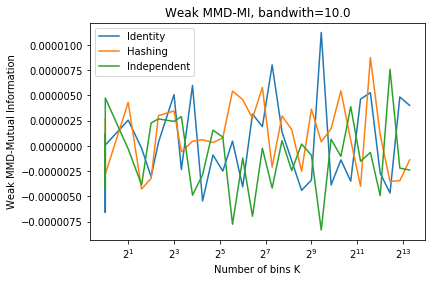

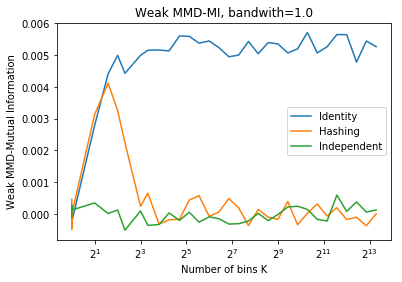

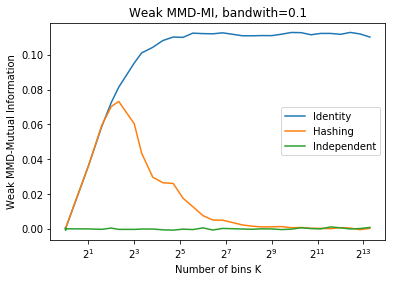

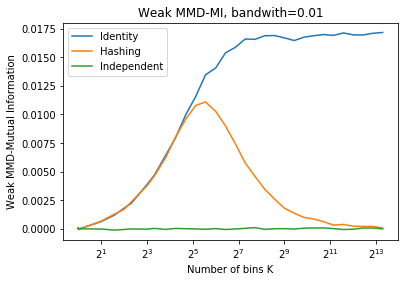

In [126]:
pretty = {
    'id': 'Identity',
    'hash': 'Hashing',
    'rand': 'Independent',    
}
for sigma, all_mis in all_sigma_all_mis:
    plt.figure()
    for permuter, mis in all_mis:
        plt.semilogx(K2, mis, label=pretty[permuter], basex=2)           
    plt.legend()
    plt.xlabel('Number of bins K')
    plt.ylabel('Weak MMD-Mutual Information')
    plt.title('Weak MMD-MI, bandwith={}'.format(sigma))
    plt.savefig('hashing-mmd-{}.pdf'.format(sigma))

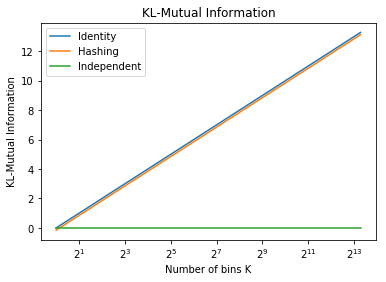

In [129]:
plt.semilogx(K2, np.log(K2)/np.log(2), label='Identity', basex=2)           
plt.semilogx(K2, -0.15+np.log(K2)/np.log(2), label='Hashing', basex=2)           
plt.semilogx(K2, 0*K2, label='Independent', basex=2)           
plt.legend()
plt.xlabel('Number of bins K')
plt.ylabel('KL-Mutual Information')
plt.title('KL-Mutual Information')
plt.savefig('hashing-kl.pdf')
